# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Classificação-de-Textos" data-toc-modified-id="Classificação-de-Textos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classificação de Textos</a></div><div class="lev2 toc-item"><a href="#Preâmbulo" data-toc-modified-id="Preâmbulo-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preâmbulo</a></div><div class="lev2 toc-item"><a href="#Procedimentos-de-treino-e-teste" data-toc-modified-id="Procedimentos-de-treino-e-teste-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Procedimentos de treino e teste</a></div><div class="lev2 toc-item"><a href="#O-Dataset" data-toc-modified-id="O-Dataset-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>O Dataset</a></div><div class="lev3 toc-item"><a href="#Lendo-do-disco" data-toc-modified-id="Lendo-do-disco-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Lendo do disco</a></div><div class="lev2 toc-item"><a href="#A-Rede-Neural" data-toc-modified-id="A-Rede-Neural-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>A Rede Neural</a></div><div class="lev3 toc-item"><a href="#Carregando-os-vetores-word2vec-para-português" data-toc-modified-id="Carregando-os-vetores-word2vec-para-português-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Carregando os vetores word2vec para português</a></div><div class="lev3 toc-item"><a href="#Preparando-a-matriz-de-embeddings" data-toc-modified-id="Preparando-a-matriz-de-embeddings-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Preparando a matriz de embeddings</a></div><div class="lev3 toc-item"><a href="#Construindo-a-rede" data-toc-modified-id="Construindo-a-rede-143"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Construindo a rede</a></div><div class="lev2 toc-item"><a href="#Treinando" data-toc-modified-id="Treinando-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Treinando</a></div><div class="lev2 toc-item"><a href="#Avaliando" data-toc-modified-id="Avaliando-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Avaliando</a></div>

# Classificação de Textos

## Preâmbulo

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

import os
import sys
import glob
import numpy as np
import numpy.random as nr

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Procedimentos de treino e teste

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, X_train, y_train, Xval, yval, 
                  opt='rmsprop', batch_size=60, nepochs=50000, patience=500, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## O Dataset

### Lendo do disco

In [4]:
dd = np.load('../../datasets/livros_sequences.npz')
Xtra, ytra_int = dd['Xtra'], dd['ytra']
Xval, yval_int = dd['Xval'], dd['yval']
i2w = dd['i2w']

seq_size = Xtra.shape[1]
n_labels = max(ytra_int) + 1

ytra = to_categorical(ytra_int, n_labels)
yval = to_categorical(yval_int, n_labels)

print('Vocabulary: {} words'.format(len(i2w)))


Vocabulary: 20000 words


## A Rede Neural

### Carregando os vetores word2vec para português

In [5]:
w2v_model_fn = '../../models/word2vec_pt_br.npz'

if not os.path.isfile(w2v_model_fn):
    wvec_words = '/Users/rubens/Development/Datasets/word2vec/portuguese/pt.tsv'

    words = []
    vectors = []
    word_index = {}
    for line in open(wvec_pt):
        line = line.rstrip()
        if line[0] != ' ':
            i, w, vec0 = line.split(maxsplit=2)
            assert int(i) == len(words)
            assert vec0[0] == '[', vec0
            words.append(w)
            vv = [float(x) for x in vec0[1:].split()]
        elif line[-1] == ']':
            vv += [float(x) for x in line[:-1].split()]
            vectors.append(vv)
        else:
            vv += [float(x) for x in line.split()]
            
    words = np.array(words)
    vectors = np.array(vects)
    np.savez_compressed(w2v_model_fn, words=words, vectors=vectors)

else:
    dd = np.load(w2v_model_fn)
    words = dd['words']
    vectors = dd['vectors']

embeddings_index = {}
for i, w in enumerate(words):
    embeddings_index[w] = vectors[i]
    
EMBEDDING_DIM = vectors.shape[1]

### Preparando a matriz de embeddings

Neste notebook o embedding é treinado a partir de pesos aleatórios.


In [6]:
nr.seed(20170601)

# prepare embedding matrix
num_words = len(i2w)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

notfound = []
for i in range(1, num_words):
    word = i2w[i]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        # words not found in embedding index will be zero
        embedding_vector = np.zeros((EMBEDDING_DIM,), np.float32)
        notfound.append(word)
    embedding_matrix[i] = embedding_vector

print('Embedding Matrix: {}.\nWords not found:  {}'.format(embedding_matrix.shape, len(notfound)))

Embedding Matrix: (20000, 300).
Words not found:  6540


### Construindo a rede

In [7]:
model_name = '../../models/livros_classif_alt_1'

def build_net(embedding_matrix=None, input_len=None, trainable=True):
    num_words, embedding_dim = embedding_matrix.shape
    
    seq_input = Input(shape=(input_len,), dtype='int32')
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix],
                                input_length=input_len, trainable=trainable)(seq_input)

    x = Conv1D(128, 5, activation='relu')(embedding_layer)
    x = MaxPooling1D(5)(x)

    x = Dropout(0.5)(x)
    
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    x = Dropout(0.5)(x)
    
    preds = Dense(n_labels, activation='softmax')(x)

    model = Model(seq_input, preds)
    return model

model = build_net(embedding_matrix, seq_size, False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 128)          192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 95, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 47, 128)           0         
__________

## Treinando

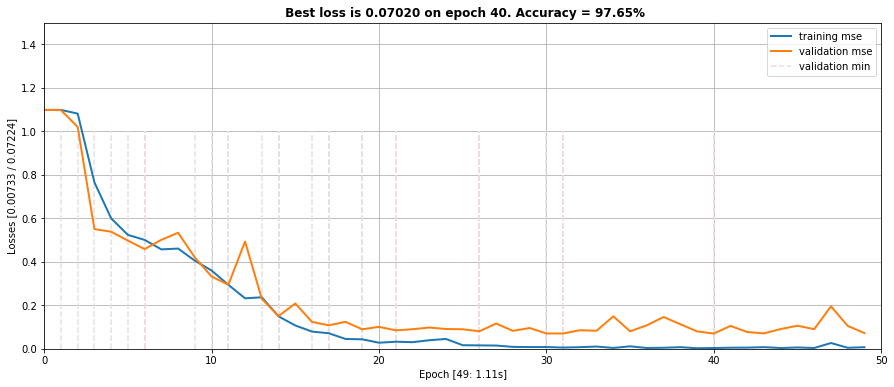

In [8]:

fit_params = {
    'opt':        Adam(0.0001),      #SGD(lr=0.001, momentum=0.9, nesterov=True), 
    'batch_size': 32, 
    'nepochs':    50,
    'patience':   15,
    'ploss':      1.5,
    'reset':      True,
}

train_network(model, model_name, Xtra, ytra, Xval, yval, **fit_params);

## Avaliando

In [9]:
test_network(model_name, Xval, yval)

Model from epoch 40
[INFO] evaluating in the test data set ...
510/510 [==============================] - 1s     

[INFO] accuracy on the test data set: 97.65% [0.07020]
